In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import hmp
from mne.io import read_info
import warnings
import pandas as pd
from utils import latency_model_fit, r_squared
import bambi as bmb
import arviz as az
from scipy.stats import gamma
from mne.viz import plot_topomap
from scipy.signal import windows
from mne.stats import permutation_cluster_1samp_test
from matplotlib.lines import Line2D 

eeg_data_path = os.path.join('data','preprocessed/')#Declaring path where the eeg data is
subj_names = [x.split('.')[0] for x in os.listdir(eeg_data_path) if '.fif' in x]#Extracting subject name based on the file name
subj_files = [eeg_data_path+x+'.fif' for x in subj_names]#Create a list of files that can be read from the folder

# Load sensor position for an example participants (assumes all have the same channel position)
info = read_info(subj_files[0], verbose=True)

sfreq = info['sfreq'] #at what sampling rate we want the data, replace with 100Hz for speed/RAM
tstep = (1000/sfreq) #Time step for plotting

epoch_data = hmp.io.read_mne_data(subj_files, epoched=True, sfreq=sfreq, 
                                     lower_limit_rt=.1,
                                     offset_after_resp=.01,#add 10ms, avoid edge effects
                                     reject_threshold=1e-4,
                                     verbose=True,
                                     subj_idx=subj_names)
epoch_data

Processing participant data/preprocessed/6_epo.fif's epoched eeg
Reading /home/gabriel/ownCloud/projects/RUGUU/decision_times/data/preprocessed/6_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    3000.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
1116 matching events found
No baseline correction applied
0 projection items activated
Applying reaction time trim to keep RTs between 0.1 and 2.991953125 seconds
1093 RTs kept of 1116 clean epochs
0 trial rejected based on threshold of 0.0001
1093 trials were retained for participant data/preprocessed/6_epo.fif
End sampling frequency is 512.0 Hz
Processing participant data/preprocessed/19_epo.fif's epoched eeg
Reading /home/gabriel/ownCloud/projects/RUGUU/decision_times/data/preprocessed/19_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    3000.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
1116 matching events found
No bas

<xarray.Dataset> Size: 11GB
Dimensions:      (participant: 26, epochs: 1117, channels: 32, samples: 1533)
Coordinates:
  * epochs       (epochs) int64 9kB 0 1 2 3 4 5 ... 1112 1113 1114 1115 1116
  * channels     (channels) <U3 384B 'Fp1' 'AF3' 'F7' 'F3' ... 'Fp2' 'Fz' 'Cz'
  * samples      (samples) int64 12kB 0 1 2 3 4 5 ... 1528 1529 1530 1531 1532
    event_name   (participant, epochs) object 232kB 'stimulus/59' ... nan
    rt           (participant, epochs) float64 232kB 0.7383 0.5039 ... nan
    condition    (participant, epochs) object 232kB 'accuracy' ... nan
    side         (participant, epochs) object 232kB 'right' 'right' ... nan
    stimulus     (participant, epochs) object 232kB '59' '55' '93' ... '89' nan
    response     (participant, epochs) object 232kB 'right' 'right' ... nan
  * participant  (participant) <U6 624B '6_epo' '19_epo' ... '2_epo' '8_epo'
Data variables:
    data         (participant, epochs, channels, samples) float64 11GB -3.684...
Attributes:
    sfreq:             512.0
    offset:            5
    lowpass:           40.0
    highpass:          0.0
    lower_limit_rt:    0.1
    upper_limit_rt:    2.991953125
    reject_threshold:  0.0001
    n_trials:          28126

# Illustration

In [2]:
colors_cond = colors = {'accuracy':'royalblue', 'speed':'indianred'}
color_model = {'linear':'k','pieron':'darkgreen','fechner':'goldenrod'}
sat_ax = {'speed':1, 'accuracy':0}
nice_names = {'fechner':r'$Fechner$', 'linear':r'$Linear$', 'pieron':r'$Pi\acute{e}ron$'}

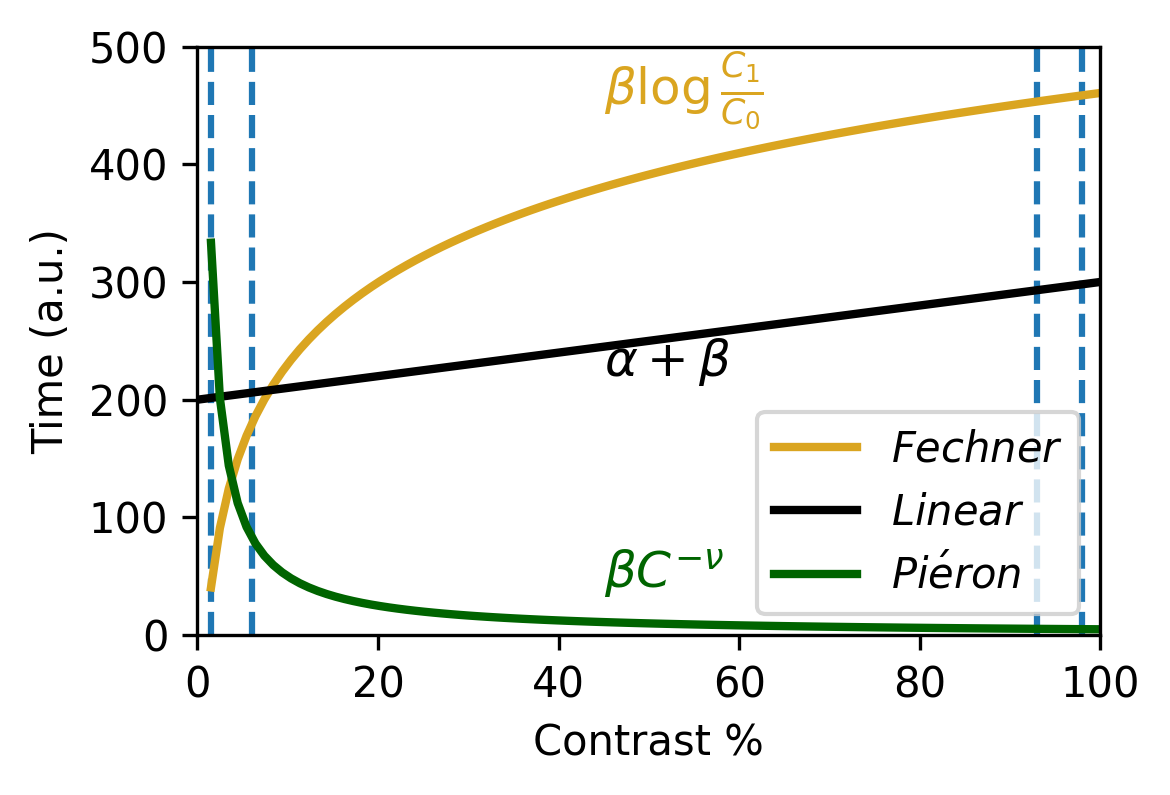

In [3]:
fig, ax = plt.subplots(1,1, dpi=300, figsize=(4,2.75))

ax.vlines(1.5, 0, 500, ls='--')
ax.vlines(6, 0, 500, ls='--')
ax.vlines(93, 0, 500, ls='--')
ax.vlines(98, 0, 500, ls='--')

ranges = np.linspace(1.5,100,101)
ax.plot(ranges, np.log(ranges)/10*1000, color=color_model['fechner'], alpha=1, lw=2, label=r'$Fechner$')
ax.plot((0,100), (200,300), color=color_model['linear'], alpha=1, lw=2, label=r'$Linear$')
ax.plot(ranges,(1/(ranges))*500, color=color_model['pieron'], alpha=1, lw=2, label=r'$Pi\acute{e}ron$')
ax.set_xlabel('Contrast levels %')

ax.plot()
ax.set_xlabel('Contrast %')
ax.set_ylabel('Time (a.u.)')
ax.set_ylim(-0.005, 300)
ax.set_ylim(-0.005, 500)
ax.set_xlim(0,100)
ax.text(45, 450, r'$\beta \log{\frac{C_1}{C_0}}$', fontsize=12, color=color_model['fechner'])
ax.text(45, 220, r'$\alpha + \beta$', fontsize=12, color=color_model['linear'])
ax.text(45, 40, r'$\beta C^{-\nu}$', fontsize=12, color=color_model['pieron'])
plt.legend()
plt.tight_layout()
plt.savefig('plots/laws.png',dpi=300,transparent=True,bbox_inches='tight')


# Analyzing behavior

In [4]:
behav_data = epoch_data.sel(samples=0, channels='Cz').to_dataframe().iloc[:,3:].reset_index()#Extracting metadata to nalyze behavior
behav_data = behav_data[~behav_data.rt.isna()]#Removing trials without responses
behav_data['correct'] = behav_data.side == behav_data.response
behav_data['contrast'] = behav_data.stimulus.astype(float)

behav_data.rt *= 1000

## Fitting RTs

fechner _____________________________________________________
('accuracy',)
41.23746288599635
('accuracy',):0.8463498196669439
pieron _____________________________________________________
('accuracy',)
89.9331115783608
('accuracy',):0.07415923277998848
linear _____________________________________________________
('accuracy',)
44.365730687832134
('accuracy',):0.8139384215539607
Prop. corr. ('accuracy',):0.838330936973674
fechner _____________________________________________________
('speed',)
19.914701321941394
('speed',):0.2662294048195135
pieron _____________________________________________________
('speed',)
23.21951103102068
('speed',):0.0047906645240565204
linear _____________________________________________________
('speed',)
18.016450020689195
('speed',):0.3938185095405501
Prop. corr. ('speed',):0.03170658253651515


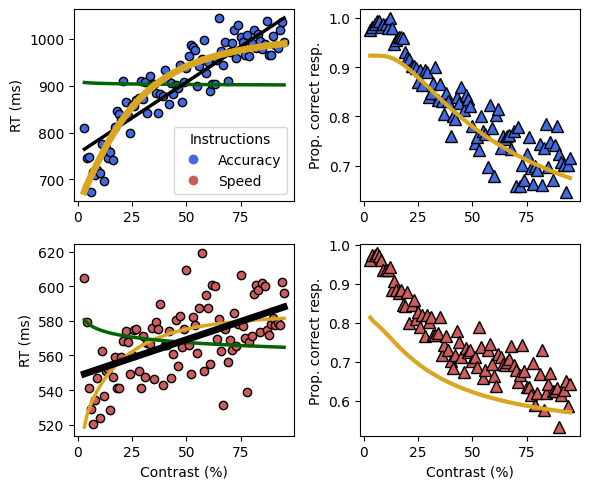

In [5]:
fig, ax = plt.subplots(2,2, figsize=(6,5), sharex=False)

for behav, behav_dat in behav_data.groupby(['condition']):    
    ax[sat_ax[behav[0]],0].plot(behav_dat.groupby(['contrast','participant']).\
                                rt.mean().groupby('contrast').mean(),'o',\
                          markeredgecolor='k', markerfacecolor=colors_cond[behav[0]], label=behav[0].capitalize())
    ax[sat_ax[behav[0]],1].plot(behav_dat.groupby(['contrast','participant']).\
                            correct.mean().groupby('contrast').mean(),'^', markersize=8,\
                      markeredgecolor='k', markerfacecolor=colors_cond[behav[0]])
    maes = []
    models = ['fechner','pieron','linear']
    preds_all, fits_all = [], []
    for model in models:
        fits, preds = latency_model_fit(behav_dat, model, 'rt', prefix=behav[0], loocv=True)
        preds = preds.groupby(['contrast','participant']).mrt.mean().groupby('contrast').mean()
        preds_all.append(preds)
        fits_all.append(np.mean(fits))
        ax[sat_ax[behav[0]],0].plot(preds, '-', color=color_model[model], lw=2.5)
        print(behav)
        print(fits)
        print(f'{behav}:{r_squared(behav_dat.groupby(['contrast','participant'])\
                            ['rt'].mean().groupby('contrast').mean(),
                    preds)}')
    winning_m = np.argmin(np.array(fits_all))
    ax[sat_ax[behav[0]],0].plot(preds_all[winning_m], '-', color=color_model[models[winning_m]], lw=5)

    preds_acc = pd.read_csv('estimation_files/'+behav[0]+'_preds_acc_fechner.csv')
    ax[sat_ax[behav[0]],1].plot(preds_acc.groupby(['contrast','participant'])\
                            .mpc.mean().groupby('contrast').mean(), color=color_model['fechner'], lw=3)
    print(f'Prop. corr. {behav}:{r_squared(behav_dat.groupby(['contrast','participant'])\
                        .correct.mean().groupby('contrast').mean(),
                preds_acc.groupby(['contrast','participant'])\
                        .mpc.mean().groupby('contrast').mean())}')
    if sat_ax[behav[0]] == 1:
        ax[sat_ax[behav[0]],0].set_xlabel('Contrast (%)')
        ax[sat_ax[behav[0]],1].set_xlabel('Contrast (%)')
ax[0,0].set_ylabel('RT (ms)')
ax[1,0].set_ylabel('RT (ms)')
ax[0,1].set_ylabel('Prop. correct resp.')
ax[1,1].set_ylabel('Prop. correct resp.')

legend_elements= []
legend_elements.append(Line2D([0], [0], marker='o', lw=0, color=colors_cond['accuracy'], label='Accuracy'))
legend_elements.append(Line2D([0], [0], marker='o', lw=0, color=colors_cond['speed'], label='Speed'))
ax[0,0].legend(handles=legend_elements, loc='lower right', title='Instructions')

fig.tight_layout()
fig.savefig('plots/latencies_fit_RT.png',dpi=300,transparent=True,bbox_inches='tight')


# Estimating HMP model

In [6]:
# Transforming data to PC space
hmp_data = hmp.utils.transform_data(epoch_data, n_comp=15, apply_zscore='participant', copy=True)
# Using defaul template
event_properties = hmp.models.base.EventProperties.create_expected(sfreq=hmp_data.sfreq)
# Perfroming crosscorrealtion of PC space data and template
trial_data = hmp.trialdata.TrialData.from_standard_data(data=hmp_data, template=event_properties.template)
# Use a cumulative fit to infer the number of events
model = hmp.models.CumulativeEstimationModel(event_properties)
model.fit(trial_data)
hmp.io.save_model(model, 'estimation_files/model')


  0%|          | 0/376 [00:00<?, ?it/s]

Transition event 1 found around time 99.609375
Transition event 2 found around time 292.96875
Transition event 3 found around time 693.359375

All events found, refitting final combination.
Estimating 3 events model


In [7]:
# # load to avoid long-ish estimation
# model = hmp.io.load_model('estimation_files/model')

# Use fitted model parameters to transform the data in event probability space
_, estimates = model.fitted_model.transform(trial_data)
hmp.io.save_model(estimates, 'estimation_files/estimates')


## Plotting model components

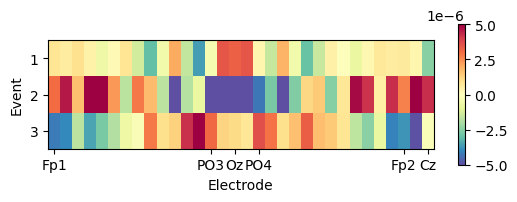

In [8]:
fig, ax = plt.subplots(figsize=(5.5,2))
weights = hmp.utils.event_topo(epoch_data, estimates, mean=True)
plt.imshow(weights[:,0,:].T, cmap='Spectral_r', aspect=3, vmin=-5e-6, vmax=5e-6, interpolation="none",)
plt.colorbar()
plt.ylabel('Event')
plt.xlabel('Electrode')
sel_elec = np.isin(weights.channels,['Fp1','Fp2','PO3','PO4','Cz', 'Oz'])
plt.yticks(range(3), [1,2,3])
plt.xticks(np.arange(len(weights.channels))[sel_elec], weights.channels.values[sel_elec])
plt.tight_layout()
plt.savefig("plots/elec_contribution.png", transparent=True, dpi=300)

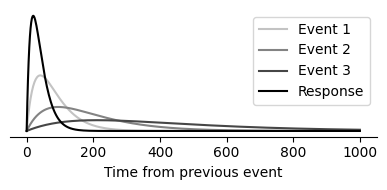

In [9]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
stages = np.linspace(0.35,1,len(model.fitted_model.magnitudes[0])+1)

stage_grey = {x: plt.cm.Greys(x) for x in stages}
stages = np.linspace(0.25,1,len(estimates.event))

x = np.linspace (0, sfreq, int(sfreq)) 
for i,dist in enumerate(model.fitted_model.parameters[0][:-1]):
    dens = gamma.pdf(x, a=dist[0], scale=dist[1])
    ax.plot(x*tstep, dens, label=f'Event {i+1}', color=stage_grey[list(stage_grey.keys())[i]]) 
dist = model.fitted_model.parameters[0][-1]
dens = gamma.pdf(x, a=dist[0], scale=dist[1])
ax.plot(x*tstep, dens, label=f'Response', color=stage_grey[list(stage_grey.keys())[i+1]])
ax.set_xlabel('Time from previous event')
ax.spines[['right', 'top', 'left']].set_visible(False)
ax.set_yticks([])
plt.legend()
plt.tight_layout()
plt.savefig("plots/interval_dist.png", transparent=True, dpi=300)

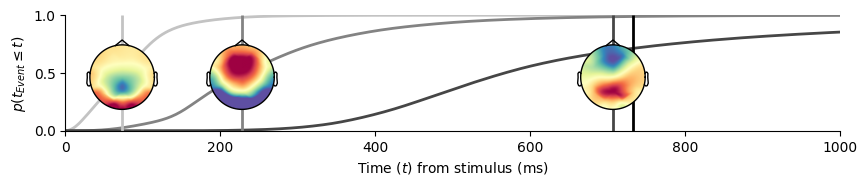

In [10]:
avg_times = hmp.utils.event_times(estimates, mean=True, add_rt=True, as_time=True)
stages = np.linspace(0.35,1,len( model.fitted_model.parameters[0]))
stage_col = [plt.cm.Greys(x) for x in stages]

fig, ax = plt.subplots(1,figsize=(10,1.5), sharex=True)

_ = hmp.visu.plot_topo_timecourse(epoch_data, estimates, info, as_time=True, ax=ax, event_lines=None, 
                 vmin=-5e-6, vmax=5e-6, colorbar=False, max_time=1000, contours=False, magnify=1.25,
                 times_to_display=np.array([1100]))

for i,ev in enumerate(estimates.event):
    probs = estimates.sel(event=ev, samples=range(1*int(sfreq))).mean('trial_x_participant')
    ax.plot(x*tstep, np.cumsum(probs), color=stage_col[i], lw=2) 

ax.vlines(avg_times, np.repeat(1, len(estimates.event)+1), 
          np.repeat(0, len(estimates.event)+1), 
          color=stage_col, lw=2)
ax.set_ylabel(r'$p (t_{Event} \leq t)$')
ax.spines[['right', 'top']].set_visible(False)
ax.spines[['left']].set_visible(True)

ax.set_xlim(0, 1000)
ax.set_yticks([0,0.5,1])
ax.set_xlabel(r'Time ($t$) from stimulus (ms)')
# plt.tight_layout()
fig.savefig('plots/HMP_solution.png', dpi=300, transparent=True, bbox_inches='tight')

In [11]:
# Compute max likely time for each trial and each event
times =  hmp.utils.event_times(estimates, duration=True, add_rt=True, as_time=True).unstack().to_dataframe(name='duration')
times = times[~times.duration.isna()]  #Remove rejected trials
times = times.reset_index().set_index(['participant','trials'])

# Recover metadata and merge with times
times_metadata = epoch_data.sel(samples=0, channels='Cz').to_dataframe().iloc[:,3:]
times_metadata = times_metadata.reset_index().rename({'epochs':'trials'}, axis=1).set_index(['participant','trials'])
times = times.merge(times_metadata, on=['participant','trials'])

# Esthetics
times = times.rename({'stimulus':'contrast'},axis=1)
times.contrast = times.contrast.astype(int)
times['correct'] = times.side == times.response
times.rt *= 1000
times = times.reset_index()

# Coding for the linear models
times['rec_sat'] = np.where(times['condition'] == 'speed', 0,
                                         np.where(times['condition'] == 'accuracy', 1, np.nan))
times['rec_cont'] = times.contrast/100 

# Analyzing inter-event times

## Testing psychological laws

fechner _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('accuracy', np.int64(0))
3.5104345429655157
('accuracy', np.int64(0)):0.2910277092101925
pieron _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('accuracy', np.int64(0))
4.055368211394429
('accuracy', np.int64(0)):0.05514120299844971
linear _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('accuracy', np.int64(0))
3.4326956133221156
('accuracy', np.int64(0)):0.32597600141393734
fechner _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('accuracy', np.int64(1))
10.644234313591435
('accuracy', np.int64(1)):-0.052873022060760055
pieron _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('accuracy', np.int64(1))
8.837226282380286
('accuracy', np.int64(1)):0.24801447248297337
linear _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('accuracy', np.int64(1))
9.496785073497273
('accuracy', np.int64(1)):0.1500386375338385
fechner _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('accuracy', np.int64(2))
39.93307093754026
('accuracy', np.int64(2)):0.8617382802440615
pieron _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('accuracy', np.int64(2))
90.16819958085479
('accuracy', np.int64(2)):0.0895955354216511
linear _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('accuracy', np.int64(2))
44.88306523662323
('accuracy', np.int64(2)):0.8094605587101622
fechner _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('accuracy', np.int64(3))
1.2988910478990716
('accuracy', np.int64(3)):0.03210265726999473
pieron _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('accuracy', np.int64(3))
1.2917665956376254
('accuracy', np.int64(3)):-0.012846258229172625
linear _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('accuracy', np.int64(3))
1.257767827995642
('accuracy', np.int64(3)):0.06494042806587874
fechner _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('speed', np.int64(0))
3.0812138187209643
('speed', np.int64(0)):0.08270735241898397
pieron _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('speed', np.int64(0))
3.2025302585692756
('speed', np.int64(0)):-0.051321254042433706
linear _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('speed', np.int64(0))
2.7810327761619504
('speed', np.int64(0)):0.25781769241448793
fechner _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('speed', np.int64(1))
10.309571044611623
('speed', np.int64(1)):0.11780859650162456
pieron _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('speed', np.int64(1))
6.9455393241954
('speed', np.int64(1)):0.6239115697766662
linear _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('speed', np.int64(1))
8.535561582411802
('speed', np.int64(1)):0.4295719157637341
fechner _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('speed', np.int64(2))
17.484826802351584
('speed', np.int64(2)):0.560328575793964
pieron _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('speed', np.int64(2))
24.725930036584373
('speed', np.int64(2)):0.1031663192905724
linear _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('speed', np.int64(2))
17.48959568272791
('speed', np.int64(2)):0.5659000270009742
fechner _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('speed', np.int64(3))
1.0945114213850826
('speed', np.int64(3)):0.059733044648856315
pieron _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('speed', np.int64(3))
1.105911519639276
('speed', np.int64(3)):0.019077334141341495
linear _____________________________________________________


/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


('speed', np.int64(3))
1.056414764422955
('speed', np.int64(3)):0.0918029096172337


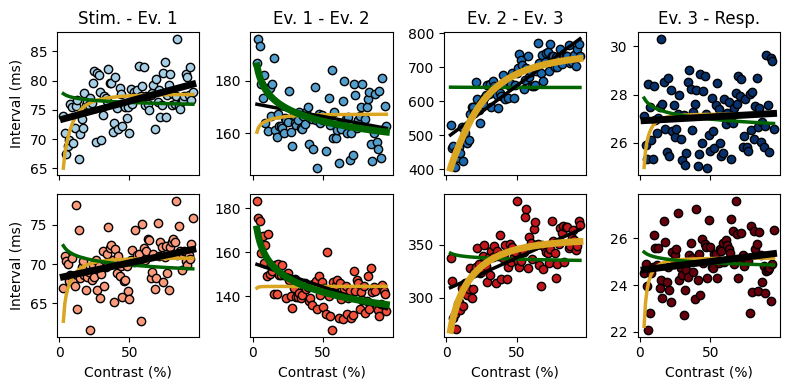

In [12]:
stage = {x: plt.cm.Reds(x) for x in stages}
stage_accuracy = {x: plt.cm.Blues(x) for x in stages}
color_stages = {'speed':stage, 'accuracy':stage_accuracy}

fig, ax = plt.subplots(2,len(times.event.unique()), figsize=(8,4), sharex=True)

titles = ['Stim. - Ev. 1', 'Ev. 1 - Ev. 2', 'Ev. 2 - Ev. 3', 'Ev. 3 - Resp.']

for stage, stage_dat in times.groupby(['condition','event']):
    sat_color_stage = color_stages[stage[0]][list(color_stages[stage[0]].keys())[stage[1]]]
    
    ax[sat_ax[stage[0]], stage[1]].plot(stage_dat.groupby(['contrast','participant']).\
                                duration.mean().groupby('contrast').mean(),'o', markeredgecolor='k', markerfacecolor=sat_color_stage)
    maes = []
    models = ['fechner','pieron','linear']
    preds_all, fits_all = [], []
    for m in models:
        fits, preds = latency_model_fit(stage_dat, m, 'duration', prefix=stage[0]+'_'+str(stage[1]), loocv=True)
        preds = preds.groupby(['contrast','participant']).mrt.mean().groupby('contrast').mean()
        preds_all.append(preds)
        fits_all.append(np.mean(fits))
        ax[sat_ax[stage[0]], stage[1]].plot(preds, '-', color=color_model[m], lw=2.5)
        print(stage)
        print(fits)
        print(f"{stage}:{r_squared(stage_dat.groupby(['contrast','participant'])['duration'].mean().groupby('contrast').mean(),preds)}")
    winning_m = np.argmin(np.array(fits_all))
    ax[sat_ax[stage[0]], stage[1]].plot(preds_all[winning_m], '-', color=color_model[models[winning_m]], lw=5)
    if sat_ax[stage[0]] == 1:
        ax[sat_ax[stage[0]], stage[1]].set_xlabel('Contrast (%)')
    else:
        ax[sat_ax[stage[0]], stage[1]].set_title(titles[stage[1]])
ax[0,0].set_ylabel('Interval (ms)')
ax[1,0].set_ylabel('Interval (ms)')

fig.tight_layout()

fig.savefig('plots/latencies_fit.png',dpi=300,transparent=True,bbox_inches='tight')

## Predicting accuracy

('accuracy', np.int64(0)):-3.358710840076454
('accuracy', np.int64(1)):-7.203096592488201
('accuracy', np.int64(2)):0.8530265172678968
('accuracy', np.int64(3)):-6.2474314493354415
('speed', np.int64(0)):-2.210256816478385
('speed', np.int64(1)):-4.693692864033446
('speed', np.int64(2)):0.6013886264051527
('speed', np.int64(3)):-2.474268376654135


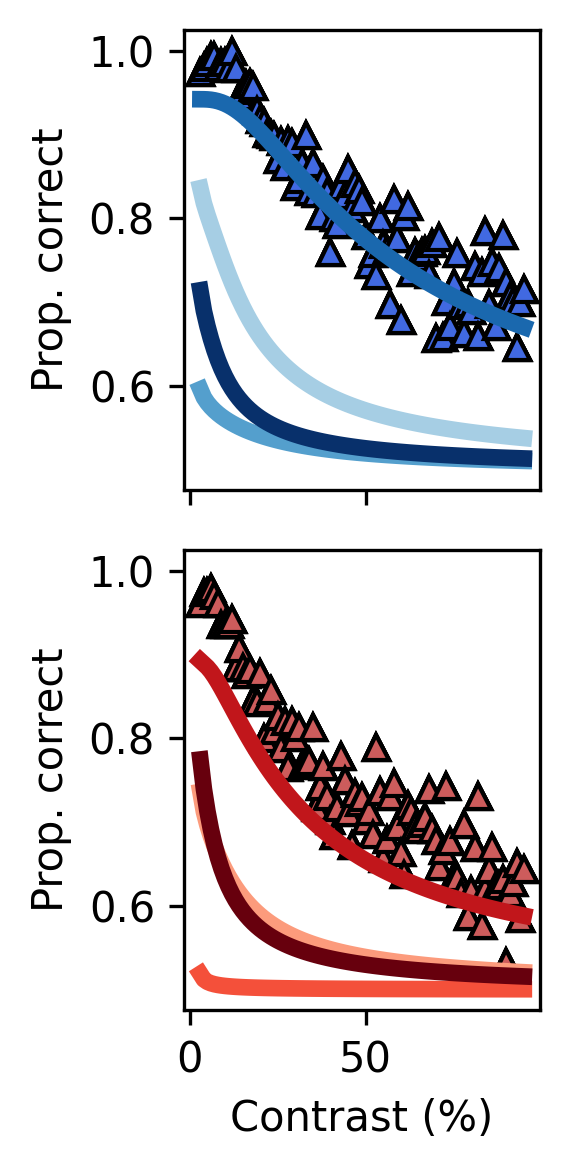

In [13]:

fig_acc, ax_acc = plt.subplots(2, figsize=(2,4), sharex=True, sharey=True, dpi=300)

for stage, stage_dat in times.groupby(['condition','event']):
    sat_color_stage = color_stages[stage[0]][list(color_stages[stage[0]].keys())[stage[1]]]
    models = ['fechner','linear']
    preds_acc = pd.read_csv('estimation_files/'+stage[0]+'_'+str(stage[1])+'_preds_acc_fechner.csv')
    ax_acc[sat_ax[stage[0]]].plot(stage_dat.groupby(['contrast','participant'])\
                            .correct.mean().groupby('contrast').mean(),'^', markersize=6, markeredgecolor='k', markerfacecolor=colors_cond[stage[0]],zorder=-1)
    ax_acc[sat_ax[stage[0]]].plot(preds_acc.groupby(['contrast','participant'])\
                            .mpc.mean().groupby('contrast').mean(), color=sat_color_stage, lw=4)
    print(f"{stage}:{r_squared(stage_dat.groupby(['contrast','participant']).correct.mean().groupby('contrast').mean(),preds_acc.groupby(['contrast','participant']).mpc.mean().groupby('contrast').mean())}")
    if sat_ax[stage[0]] == 1:
        ax_acc[sat_ax[stage[0]]].set_xlabel('Contrast (%)')

ax_acc[0].set_ylabel('Prop. correct')
ax_acc[1].set_ylabel('Prop. correct')
fig_acc.tight_layout()
fig_acc.savefig('plots/latencies_fechneracc.png',dpi=300,transparent=True,bbox_inches='tight')

## Linear mixed models

In [14]:
fits_time = {}
for event, event_dat in times.groupby('event'):
    amp_model = bmb.Model("duration ~ rec_cont + rec_sat + rec_cont:rec_sat + (rec_cont + rec_sat + rec_cont:rec_sat | participant)", 
                               event_dat, 
                               family="gaussian", dropna=True)
    fits_time[event] = amp_model.fit()


Initializing NUTS using jitter+adapt_diag...
/home/gabriel/venv/hmp_refactor/lib/python3.12/site-packages/pytensor/link/c/cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, rec_cont, rec_sat, rec_cont:rec_sat, 1|participant_sigma, 1|participant_offset, rec_cont|participant_sigma, rec_cont|participant_offset, rec_sat|participant_sigma, rec_sat|pa

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 99 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, rec_cont, rec_sat, rec_cont:rec_sat, 1|participant_sigma, 1|participant_offset, rec_cont|participant_sigma, rec_cont|participant_offset, rec_sat|participant_sigma, rec_sat|participant_offset, rec_cont:rec_sat|participant_sigma, rec_cont:rec_sat|participant_offset]
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 132 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, rec_cont, rec_sat, rec_cont:rec_sat, 1|participant_sigma, 1|participant_offset, rec_cont|participant_sigma, rec_cont|participant_offset, rec_sat|participant_sigma, rec_sat|participant_offset, rec_cont:rec_sat|participant_sigma, rec_cont:rec_sat|participant_offset]
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 246 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, rec_cont, rec_sat, rec_cont:rec_sat, 1|participant_sigma, 1|participant_offset, rec_cont|participant_sigma, rec_cont|participant_offset, rec_sat|participant_sigma, rec_sat|participant_offset, rec_cont:rec_sat|participant_sigma, rec_cont:rec_sat|participant_offset]
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.


In [15]:
keys = list(fits_time[1].posterior.data_vars.keys())
group_pars = [keys[i] for i in [0, 1, 2, 3, 4]]

for event in times.event.unique():
    print(az.summary(fits_time[event], hdi_prob=.95, var_names=group_pars))

                    mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
sigma             38.073  0.160    37.773     38.395      0.002    0.003   
Intercept         68.297  1.758    64.801     71.741      0.067    0.038   
rec_cont           3.664  2.174    -0.677      7.779      0.063    0.041   
rec_sat            5.015  1.166     2.683      7.187      0.023    0.016   
rec_cont:rec_sat   2.607  1.805    -1.094      5.922      0.030    0.028   

                  ess_bulk  ess_tail  r_hat  
sigma               7800.0    3104.0    1.0  
Intercept            688.0    1289.0    1.0  
rec_cont            1212.0    1582.0    1.0  
rec_sat             2472.0    2875.0    1.0  
rec_cont:rec_sat    3624.0    2960.0    1.0  
                     mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
sigma              84.667  0.353    83.980     85.359      0.005    0.006   
Intercept         154.947  4.710   145.778    164.310      0.166    0.106   
rec_cont          -21.758  3.806   -

# Electrode activity

In [16]:
# Average event topography for each event
elecs_sp = hmp.utils.event_topo(epoch_data, estimates, mean=True)

# Elec activity at single-trial event time points
speed_amp = hmp.utils.event_topo(epoch_data, estimates, mean=False)
speed_amp.name = 'amplitudes'
speed_data_merge = hmp_data.sel(component=0,samples=0).unstack().stack({'trial_x_participant':['participant','epochs']}).dropna('trial_x_participant', how="all").stimulus.unstack()
speed_data_merge.name = 'contrast'
speed_data_merge = speed_data_merge.rename({'epochs':'trials'})

# Get multivariate pattern time-course
mvp_amplitudes = np.zeros((speed_amp.sizes['event'],speed_amp.sizes['trial_x_participant']))
for event in speed_amp.event:
    mvp_amplitudes[event] = elecs_sp.sel(event=event) @ speed_amp.sel(event=event)
mvp_amplitudes = xr.DataArray(mvp_amplitudes.T,
                                   coords=speed_amp.sel(channels='Cz').squeeze().coords,
                                   name='amplitudes')
mvp_amplitudes = xr.merge([mvp_amplitudes.unstack(), speed_data_merge]).to_dataframe()
mvp_amplitudes = mvp_amplitudes[~mvp_amplitudes.amplitudes.isna()]# Rejected trials

# Standardize for the LMM and recode SAT and contrast
mvp_amplitudes.amplitudes = (mvp_amplitudes.amplitudes)/mvp_amplitudes.amplitudes.std()
mvp_amplitudes['rec_sat'] = np.where(mvp_amplitudes['condition'] == 'speed', 0,
                    np.where(mvp_amplitudes['condition'] == 'accuracy', 1, np.nan))
mvp_amplitudes.contrast = mvp_amplitudes.contrast.astype(float)/100
mvp_amplitudes = mvp_amplitudes.reset_index()


## Linear mixed models

In [17]:
fits_amp = {}
for event, event_dat in mvp_amplitudes.groupby('event'):
    amp_model = bmb.Model("amplitudes ~ contrast + rec_sat + contrast:rec_sat + (contrast + rec_sat + contrast:rec_sat | participant)", 
                               event_dat, family="gaussian", dropna=True)
    fits_amp[event] = amp_model.fit()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, contrast, rec_sat, contrast:rec_sat, 1|participant_sigma, 1|participant_offset, contrast|participant_sigma, contrast|participant_offset, rec_sat|participant_sigma, rec_sat|participant_offset, contrast:rec_sat|participant_sigma, contrast:rec_sat|participant_offset]
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 100 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, contrast, rec_sat, contrast:rec_sat, 1|participant_sigma, 1|participant_offset, contrast|participant_sigma, contrast|participant_offset, rec_sat|participant_sigma, rec_sat|participant_offset, contrast:rec_sat|participant_sigma, contrast:rec_sat|participant_offset]
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 106 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, contrast, rec_sat, contrast:rec_sat, 1|participant_sigma, 1|participant_offset, contrast|participant_sigma, contrast|participant_offset, rec_sat|participant_sigma, rec_sat|participant_offset, contrast:rec_sat|participant_sigma, contrast:rec_sat|participant_offset]
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=204452) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 148 seconds.


In [18]:
keys = list(fits_amp[1].posterior.data_vars.keys())
group_pars = [keys[i] for i in [0, 1, 2, 3, 4]]

for event in mvp_amplitudes.event.unique():
    print(az.summary(fits_amp[event], hdi_prob=.95, var_names=group_pars))

                   mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
sigma             0.252  0.001     0.250      0.255      0.000      0.0   
Intercept         0.197  0.014     0.167      0.223      0.001      0.0   
contrast          0.040  0.011     0.017      0.062      0.000      0.0   
rec_sat           0.020  0.008     0.003      0.036      0.000      0.0   
contrast:rec_sat  0.014  0.012    -0.008      0.037      0.000      0.0   

                  ess_bulk  ess_tail  r_hat  
sigma               6912.0    2875.0   1.00  
Intercept            487.0     873.0   1.01  
contrast            1503.0    2135.0   1.00  
rec_sat             1845.0    2501.0   1.00  
contrast:rec_sat    2630.0    3077.0   1.00  
                   mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
sigma             1.103  0.005     1.094      1.111      0.000    0.000   
Intercept         1.333  0.066     1.199      1.452      0.003    0.001   
contrast         -0.023  0.061    -0.147      0.